In [1]:
import sys; sys.path.insert(0, '../../external/')

%run ../initlibs.py cryptomomentum dark
from models.research_utils import load_data
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline


import ira
%alphalab

from alpha.utils.data_helpers import FriendlyFxLoader

from qlearn.tracking.trackers import Tracker, TakeStopTracker, TurtleTracker, DispatchTracker, PipelineTracker, TimeExpirationTracker
from qlearn.core.base import BasicMarketEstimator, MarketDataComposer
from qlearn.core.pickers import SingleInstrumentPicker

from models.Q_models import *

Reloaded ../../external/ira/experimental/c_simulator_core.pyx


In [2]:
timeframe = '5Min'
t_shift = pd.Timedelta(timeframe) - pd.Timedelta('1s')

data = ohlc_resample(load_data('BTCUSDT'), timeframe)

We will use new framework (QLearn) for development this model as it should give us more flexible approach to 
testing mixed models.
<hr/>

In [4]:
b_ents = MarketDataComposer(
    make_pipeline(RollingRange('1d', 55), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None)

b_exits = MarketDataComposer(
    make_pipeline(RollingRange('1d', 10), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None)

s = shift_signals(
    srows(
        1 * b_ents.fit(data, None).predict(data),
        2 * b_exits.fit(data, None).predict(data),
        pd.DataFrame({'BTCUSDT': 'regime:m1'}, index=pd.DatetimeIndex(['2017-10-14 15:00:00']))
    ), t_shift)

In [5]:
tracker = TurtleTracker(3000, None, max_units=4, risk_capital_pct=0.03, max_allowed_contracts=1000, pull_stops_on_incr=True, after_lose_only=False, debug=True)
p = z_backtest(s, data, 'crypto_futures', spread=0.5, execution_logger=True, trackers=tracker)

	[2018-05-05 10:14:59] -> [#1] BTCUSDT 17 @ 9901.50 x 8825.05
 -> [2018-05-11 06:59:00] stop long [BTCUSDT] at 8809.87000
	[2018-06-10 17:39:59] -> [#1] BTCUSDT -17 @ 6857.85 x 7588.31
	[2018-06-10 18:14:00] -> [#2] BTCUSDT <-6752.10> increasing to -33 @ 6639.74 x -6021.64
 -> [2018-06-10 18:14:00] stop short [BTCUSDT] at 6639.74000
	[2018-06-12 19:14:59] -> [#1] BTCUSDT -15 @ 6522.74 x 7295.73
	[2018-06-13 16:24:00] -> [#2] BTCUSDT <-6400.39> increasing to -29 @ 6269.31 x -5620.50
 -> [2018-06-13 16:24:00] stop short [BTCUSDT] at 6269.31000
	[2018-06-22 13:54:59] -> [#1] BTCUSDT -16 @ 6131.08 x 6832.99
	[2018-06-22 21:09:00] -> [#2] BTCUSDT <-6037.87> increasing to -31 @ 5938.45 x -5335.96
 -> [2018-06-22 21:09:00] stop short [BTCUSDT] at 5938.45000
	[2018-06-24 04:49:59] -> [#1] BTCUSDT -14 @ 5886.78 x 6622.84
 -> [2018-07-02 13:49:00] stop short [BTCUSDT] at 6637.17000
	[2018-07-23 18:34:59] -> [#1] BTCUSDT 21 @ 7681.13 x 7030.46
	[2018-07-24 04:49:00] -> [#2] BTCUSDT <7780.69> incr

Statistic,Model
Gain (USD):,319.51
CAGR (%):,2.097
Sharpe:,1.316
Sortino:,2.296
Calmar:,1.686
MaxDD (%):,1.584
MaxDD On Init BP (%):,1.698
MaxDD (USD):,50.952
MaxDD days:,525 days
MaxDD start:,2019-05-30

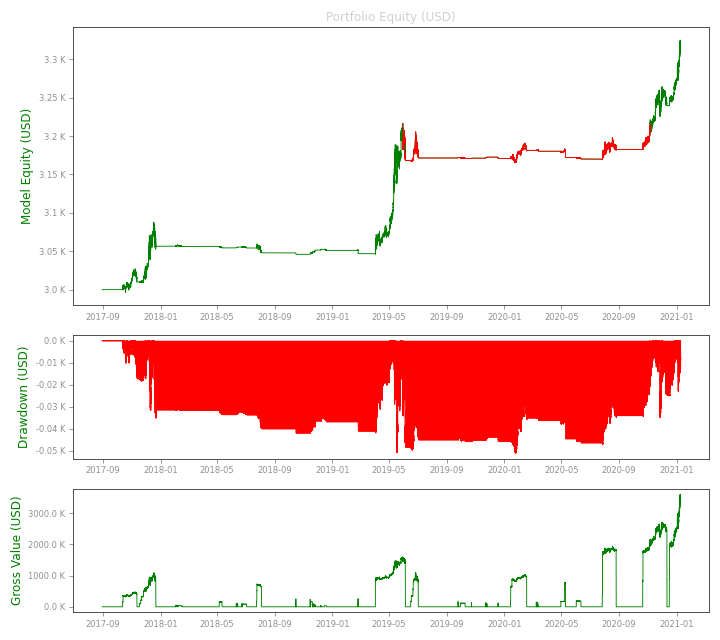

<Figure size 720x640 with 0 Axes>

In [6]:
tearsheet(p, tracker.account_size)

In [7]:
p.executions.tail()

,instrument,quantity,exec_price,comment
2020-12-11 11:39:59,BTCUSDT,-136,17609.74,
2020-12-16 13:49:59,BTCUSDT,21,20245.88,
2020-12-16 14:14:00,BTCUSDT,22,20798.60,increased position to 43 at 20798.6
2020-12-16 21:54:00,BTCUSDT,22,21267.01,increased position to 65 at 21267.01
2020-12-17 01:14:00,BTCUSDT,21,21767.82,increased position to 86 at 21767.82


# On hourly timeframe breakouts

In [9]:
b_e1h = MarketDataComposer(
    make_pipeline(RollingRange('1h', 10), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None).fit(data, None).predict(data)

b_x1h = MarketDataComposer(
    make_pipeline(RollingRange('1h', 6), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None).fit(data, None).predict(data)

s1h = shift_signals(srows(1 * b_e1h, 2 * b_x1h), '4M59Sec')

In [ ]:
p1h_s1 = z_backtest(s1h, data, 'crypto_futures', spread=0.5, execution_logger=True, 
                 trackers=TurtleTracker(
                     3000, None, max_units=4, risk_capital_pct=0.05, 
                     atr_timeframe='1h',
                     after_lose_only=True,
                     max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                )

p1h_s2 = z_backtest(s1h, data, 'crypto_futures', spread=0.5, execution_logger=True, 
                 trackers=TurtleTracker(
                     3000, None, max_units=4, risk_capital_pct=0.05, 
                     atr_timeframe='1h',
                     after_lose_only=False,
                     max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                )

Statistic,Model
Gain (USD):,1952.88
CAGR (%):,10.681
Sharpe:,1.429
Sortino:,4.444
Calmar:,1.752
MaxDD (%):,7.054
MaxDD On Init BP (%):,8.036
MaxDD (USD):,241.078
MaxDD days:,141 days
MaxDD start:,2018-10-15

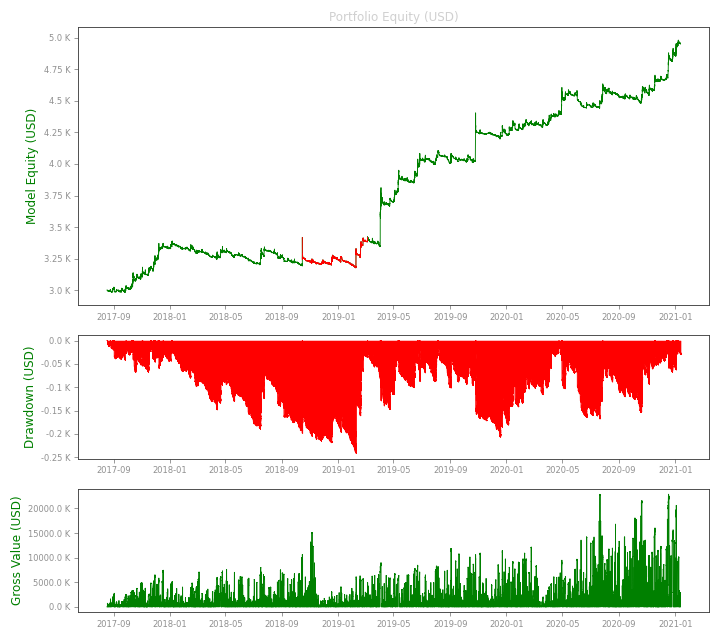
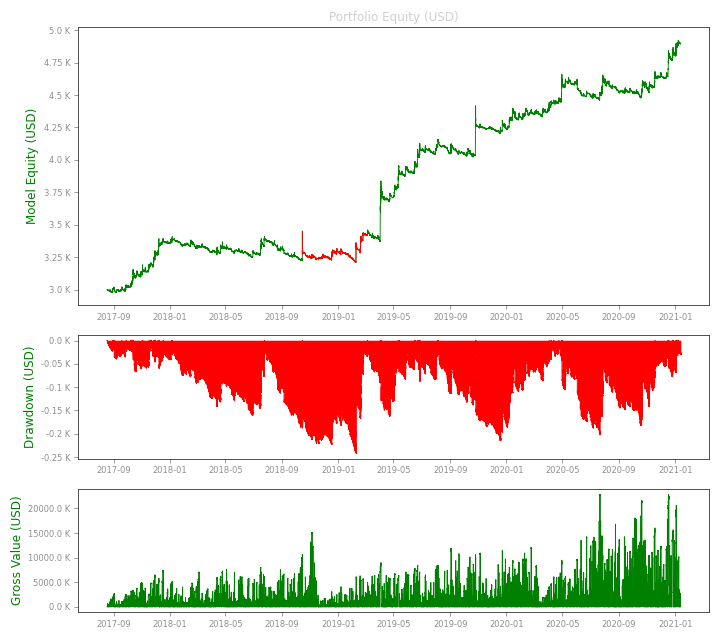

<Figure size 720x640 with 0 Axes>

<Figure size 720x640 with 0 Axes>

In [200]:
tearsheets(p1h_s1, p1h_s2,  init_cash=3000)

# Pivots generators

In [3]:
p_sigs_d = generate_pivots_signals(PivotsRange('D'), data, t_shift)
p_sigs_w = generate_pivots_signals(PivotsRange('W', 'camarilla'), data, t_shift)

In [4]:
pvt_d_s1 = z_backtest(p_sigs_d, data, 'crypto_futures', spread=0.5, execution_logger=True, 
                    trackers=TurtleTracker(
                        3000, None, max_units=4, risk_capital_pct=0.05, 
                        atr_timeframe='1h',
                        after_lose_only=True,
                        max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                    )
pvt_w_s1 = z_backtest(p_sigs_w, data, 'crypto_futures', spread=0.5, execution_logger=True, 
                    trackers=TurtleTracker(
                        3000, None, max_units=4, risk_capital_pct=0.05, 
                        atr_timeframe='1h',
                        after_lose_only=True,
                        max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                    )

Statistic,Model
Gain (USD):,2408.97
CAGR (%):,12.683
Sharpe:,1.776
Sortino:,5.225
Calmar:,3.656
MaxDD (%):,5.856
MaxDD On Init BP (%):,7.056
MaxDD (USD):,211.678
MaxDD days:,131 days
MaxDD start:,2018-10-15

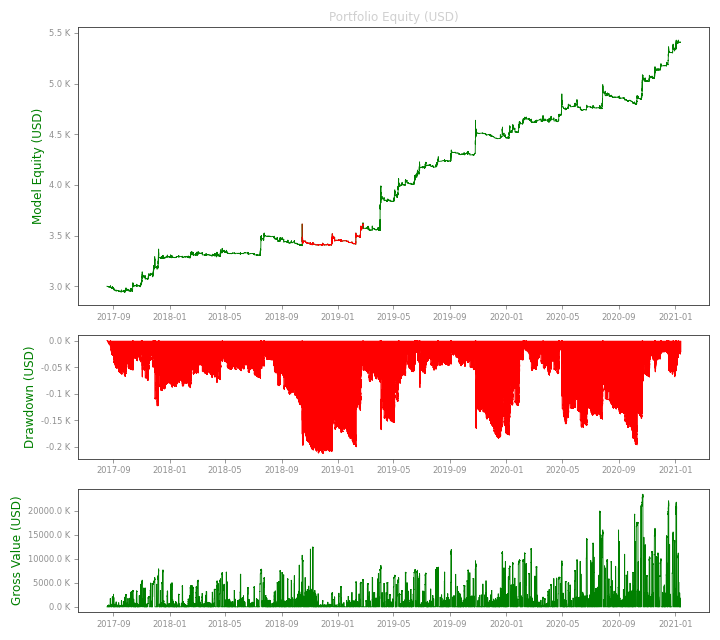

<Figure size 720x640 with 0 Axes>

In [5]:
tearsheet(pvt_d_s1, 3000)

Statistic,Model
Gain (USD):,2392.69
CAGR (%):,12.646
Sharpe:,1.446
Sortino:,2.948
Calmar:,2.138
MaxDD (%):,7.113
MaxDD On Init BP (%):,12.357
MaxDD (USD):,370.712
MaxDD days:,137 days
MaxDD start:,2020-08-02

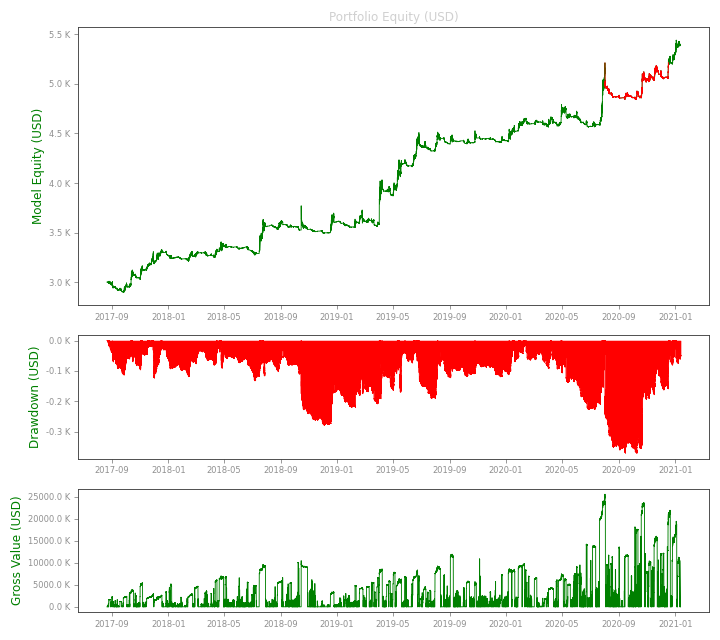

<Figure size 720x640 with 0 Axes>

In [6]:
tearsheet(pvt_w_s1, 3000)

In [ ]:
pvt_w_s1 = z_backtest(generate_pivots_signals(PivotsRange('D', 'camarilla')), 
                      data, 'crypto_futures', spread=0.5, execution_logger=True, 
                      trackers=TurtleTracker(
                          3000, None, max_units=4, risk_capital_pct=0.05, 
                          atr_timeframe='1h',
                          after_lose_only=True,
                          max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False)
                      )

Statistic,Model
Gain (USD):,2387.01
CAGR (%):,12.590
Sharpe:,1.531
Sortino:,4.598
Calmar:,2.841
MaxDD (%):,8.810
MaxDD On Init BP (%):,10.092
MaxDD (USD):,302.746
MaxDD days:,168 days
MaxDD start:,2018-10-15

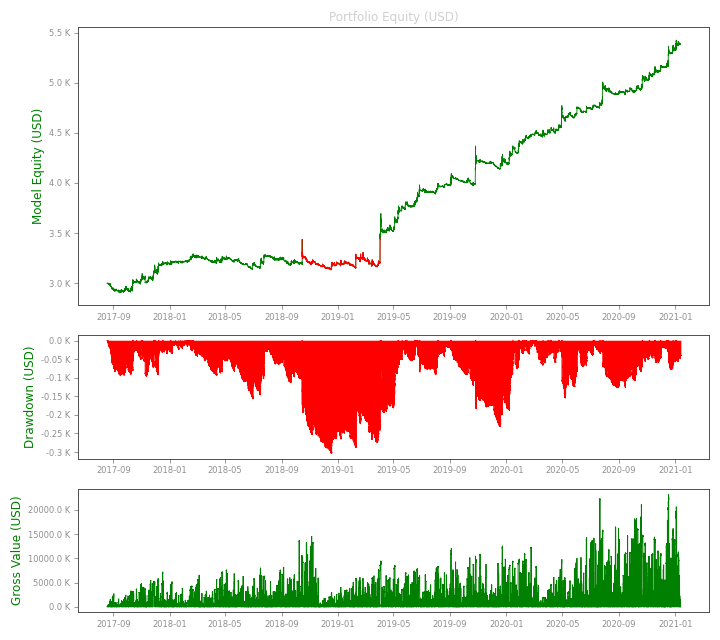

<Figure size 720x640 with 0 Axes>

In [13]:
tearsheet(pvt_w_s1, 3000)

# Regime switching

In [7]:
class NoTradingActivity(Tracker):
    def on_signal(self, signal_time, signal_qty, quote_time, bid, ask, bid_size, ask_size):
        return None

In [ ]:
pvt_w_s1_reg = z_backtest(
    generate_pivots_signals(PivotsRange('D', 'camarilla'), data, t_shift), 
    data, 'crypto_futures', spread=0.5, execution_logger=True, 
    trackers=DispatchTracker({
        
        'trend':TurtleTracker(
            3000, None, max_units=4, risk_capital_pct=0.05, 
            atr_timeframe='1h', after_lose_only=True, max_allowed_contracts=1000, pull_stops_on_incr=True, debug=False
        ),
        
        'range': NoTradingActivity()
    }, active_tracker=None, flat_position_on_activate=True)
)